In [16]:
import sys

In [17]:
print(sys.executable)

/usr/local/bin/python3


In [13]:
# Complete Boeing Stock Analysis with Dynamic Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Step 1: Import the data
def import_boeing_data(file_path='/Users/a1234567/Downloads/Data_collected.xlsx', sheet_name='2000122'):
    """
    Import Boeing stock data and exogenous variables from Excel.
    """
    try:
        # Read the data from Excel
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Check if data was loaded successfully
        if df.empty:
            print("Warning: The loaded data is empty")
            return None
        
        # Print info about the imported data
        print(f"Successfully imported data from {sheet_name}")
        print(f"Data shape: {df.shape}")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"Column names: {df.columns.tolist()}")
        
        # Convert date to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            df['date'] = pd.to_datetime(df['date'])
            
        # Sort by date to ensure time sequence is maintained
        df = df.sort_values('date')
        
        # Check for missing values
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            print("Missing values in each column:")
            print(missing_values[missing_values > 0])
            # Fill missing values with forward fill
            df = df.fillna(method='ffill')
        else:
            print("No missing values found in the data")
            
        return df
    
    except Exception as e:
        print(f"Error importing data: {e}")
        return None

In [19]:
# First, let's add debugging to see what's happening in the dynamic_regression_model function
def dynamic_regression_model(df, lags=4, test_size=0.2):
    """
    Implement Dynamic Regression model for Boeing stock prediction with extra debugging
    """
    print("Implementing Dynamic Regression model...")
    
    try:
        # Define features and target
        exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
        target = 'boeing'
        
        # Check if all columns exist in the dataframe
        missing_cols = [col for col in exog_vars + [target] if col not in df.columns]
        if missing_cols:
            print(f"Error: Missing columns in dataframe: {missing_cols}")
            return None
        
        # Extract features and target
        X = df[exog_vars].values
        y = df[target].values
        
        print(f"Feature shape: {X.shape}, Target shape: {y.shape}")
        
        # Normalize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Create a separate function for creating lagged features
        print("Creating lagged features...")
        
        # Create DataFrame to store features and lags
        data = pd.DataFrame(X_scaled, columns=exog_vars)
        data['target'] = y
        
        # Add dates for later reference
        data['date'] = df['date'].reset_index(drop=True)
        
        # Add lagged features
        feature_names = exog_vars.copy()  # Start with original feature names
        for var in exog_vars:
            for lag in range(1, lags + 1):
                lag_name = f'{var}_lag{lag}'
                data[lag_name] = data[var].shift(lag)
                feature_names.append(lag_name)
        
        # Add lagged target (autoregressive component)
        for lag in range(1, lags + 1):
            lag_name = f'target_lag{lag}'
            data[lag_name] = data['target'].shift(lag)
            feature_names.append(lag_name)
        
        # Drop rows with NaN values (from lagging)
        print(f"Shape before dropping NaNs: {data.shape}")
        data = data.dropna()
        print(f"Shape after dropping NaNs: {data.shape}")
        
        if len(data) == 0:
            print("Error: No data left after dropping NaN values")
            return None
        
        # Get dates, features and target
        dates = data['date']
        X_lagged = data[feature_names].values
        y_lagged = data['target'].values
        
        print(f"Lagged feature shape: {X_lagged.shape}, Target shape: {y_lagged.shape}")
        
        # Split into training and testing sets
        split_idx = int(len(X_lagged) * (1 - test_size))
        
        if split_idx <= 0:
            print("Error: Training set is empty. Check test_size parameter.")
            return None
        
        X_train = X_lagged[:split_idx]
        X_test = X_lagged[split_idx:]
        y_train = y_lagged[:split_idx]
        y_test = y_lagged[split_idx:]
        train_dates = dates[:split_idx]
        test_dates = dates[split_idx:]
        
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Testing set: {X_test.shape[0]} samples")
        
        # Add constant for statsmodels
        X_train_sm = sm.add_constant(X_train)
        X_test_sm = sm.add_constant(X_test)
        
        # Fit model using statsmodels OLS
        print("Fitting Dynamic Regression model...")
        model = sm.OLS(y_train, X_train_sm)
        results = model.fit()
        
        # Make predictions
        y_train_pred = results.predict(X_train_sm)
        y_test_pred = results.predict(X_test_sm)
        
        # Calculate performance metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
        
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        print("\nDynamic Regression Model Performance:")
        print(f"Training MSE: {train_mse:.2f}")
        print(f"Testing MSE: {test_mse:.2f}")
        print(f"Training R²: {train_r2:.4f}")
        print(f"Testing R²: {test_r2:.4f}")
        
        # Get coefficients
        coefficients = results.params[1:]  # Skip intercept
        
        # Create a DataFrame with feature names and coefficients
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients,
            'Absolute_Coefficient': np.abs(coefficients)
        })
        
        # Sort by absolute coefficient value
        importance_df = importance_df.sort_values('Absolute_Coefficient', ascending=False)
        
        print("\nTop 10 most important features:")
        print(importance_df.head(10))
        
        # Return results with dictionary structure explicitly defined
        return_dict = {
            'model': results,
            'metrics': {
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_mape': train_mape,
                'test_mape': test_mape,
                'train_r2': train_r2,
                'test_r2': test_r2
            },
            'importance': importance_df,
            'predictions': {
                'train_dates': train_dates,
                'test_dates': test_dates,
                'y_train': y_train,
                'y_train_pred': y_train_pred,
                'y_test': y_test,
                'y_test_pred': y_test_pred
            }
        }
        
        print("Model completed successfully")
        return return_dict
        
    except Exception as e:
        print(f"Error in dynamic_regression_model: {e}")
        import traceback
        traceback.print_exc()
        return None


In [20]:
def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted Boeing stock prices
    """
    if results is None:
        print("Error: Results is None, cannot plot")
        return None
    
    if 'predictions' not in results:
        print("Error: 'predictions' key not found in results")
        return None
    
    predictions = results['predictions']
    required_keys = ['train_dates', 'test_dates', 'y_train', 'y_train_pred', 'y_test', 'y_test_pred']
    
    for key in required_keys:
        if key not in predictions:
            print(f"Error: '{key}' not found in predictions")
            return None
    
    train_dates = predictions['train_dates']
    test_dates = predictions['test_dates']
    y_train = predictions['y_train']
    y_train_pred = predictions['y_train_pred']
    y_test = predictions['y_test']
    y_test_pred = predictions['y_test_pred']
    
    plt.figure(figsize=(16, 8))
    
    # Plot training data
    plt.plot(train_dates, y_train, label='Actual (Training)', color='blue', linewidth=2)
    plt.plot(train_dates, y_train_pred, label='Predicted (Training)', color='green', linestyle='--', linewidth=2)
    
    # Plot testing data
    plt.plot(test_dates, y_test, label='Actual (Testing)', color='red', linewidth=2)
    plt.plot(test_dates, y_test_pred, label='Predicted (Testing)', color='orange', linestyle='--', linewidth=2)
    
    plt.title('Boeing Stock Price: Actual vs. Predicted (Dynamic Regression)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price ($)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt

In [21]:
# Step 4: Plot feature importance
def plot_feature_importance(results):
    """
    Plot feature importance from the model
    """
    importance = results['importance'].head(15)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importance['Feature'], importance['Absolute_Coefficient'])
    plt.title('Feature Importance (Dynamic Regression)', fontsize=16)
    plt.xlabel('Absolute Coefficient Value', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

In [22]:
def main():
    # Step 1: Import the data - use your correct file path
    file_path = '/Users/a1234567/Downloads/Data_collected.xlsx'
    
    try:
        # Read the data from Excel
        df = pd.read_excel(file_path, sheet_name='2000122')
        
        print(f"Successfully imported data from 2000122")
        print(f"Data shape: {df.shape}")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        print(f"Column names: {df.columns.tolist()}")
        
        # Convert date to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['date']):
            df['date'] = pd.to_datetime(df['date'])
            
        # Sort by date to ensure time sequence is maintained
        df = df.sort_values('date')
        
        # Check for missing values
        missing_values = df.isnull().sum()
        if missing_values.sum() > 0:
            print("Missing values in each column:")
            print(missing_values[missing_values > 0])
            # Fill missing values with forward fill
            df = df.fillna(method='ffill')
            print("Filled missing values with forward fill")
        else:
            print("No missing values found in the data")
            
        # Step 2: Run Dynamic Regression model
        print("Running Dynamic Regression model...")
        results = dynamic_regression_model(df)
        
        if results is None:
            print("Error: Dynamic Regression model returned None")
            return
        
        # Step 3: Plot actual vs predicted
        print("Plotting actual vs predicted...")
        plot1 = plot_actual_vs_predicted(results)
        
        if plot1 is not None:
            print("Saving actual vs predicted plot...")
            plot1.savefig('boeing_actual_vs_predicted.png')
            plot1.show()
        
        print("Analysis completed successfully")
        
    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()


Successfully imported data from 2000122
Data shape: (1263, 9)
Date range: 2000-12-02 00:00:00 to 2025-02-08 00:00:00
Column names: ['date', 'boeing', 'DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
No missing values found in the data
Running Dynamic Regression model...
Implementing Dynamic Regression model...
Feature shape: (1263, 7), Target shape: (1263,)
Creating lagged features...
Shape before dropping NaNs: (1263, 41)
Shape after dropping NaNs: (1259, 41)
Lagged feature shape: (1259, 39), Target shape: (1259,)
Training set: 1007 samples
Testing set: 252 samples
Fitting Dynamic Regression model...

Dynamic Regression Model Performance:
Training MSE: 23.16
Testing MSE: 97.41
Training R²: 0.9976
Testing R²: 0.9052

Top 10 most important features:
          Feature  Coefficient  Absolute_Coefficient
21       GDP_lag3 -4442.041876           4442.041876
19       GDP_lag1  3851.725851           3851.725851
22       GDP_lag4  2713.514108           2713.514108
20       GDP_lag2 -114

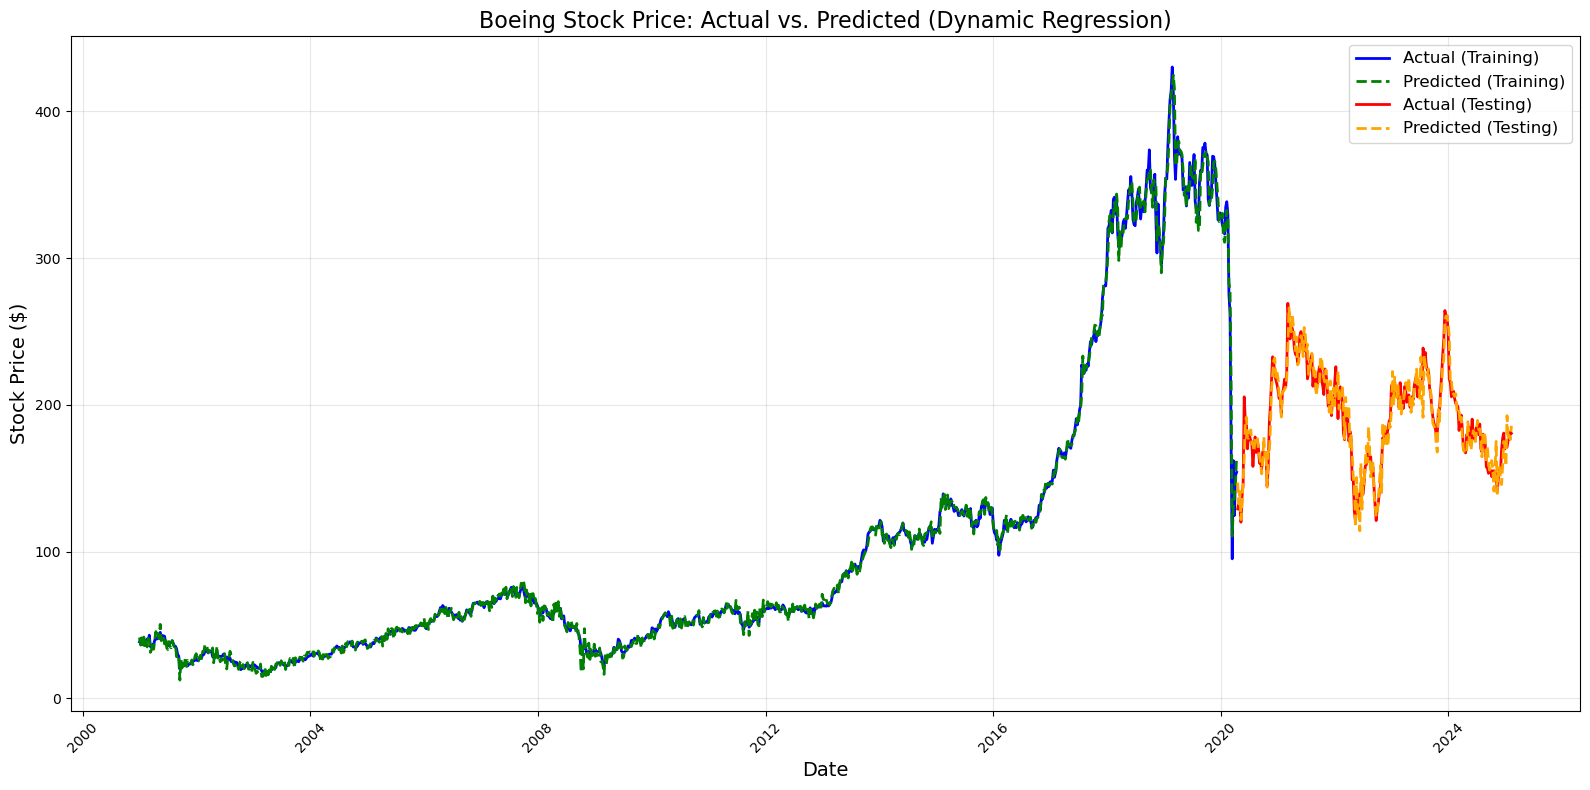

Analysis completed successfully


In [23]:
if __name__ == "__main__":
    main()

In [35]:
def plot_by_time_periods(results, num_periods=5):
    """
    Plot Boeing stock predictions divided into multiple time periods
    
    Args:
        results: Dictionary with model results and predictions
        num_periods: Number of time periods to divide the data into
    """
    # Get data from results
    train_dates = results['predictions']['train_dates']
    test_dates = results['predictions']['test_dates']
    y_train = results['predictions']['y_train']
    y_train_pred = results['predictions']['y_train_pred']
    y_test = results['predictions']['y_test']
    y_test_pred = results['predictions']['y_test_pred']
    
    # Combine all dates and data
    all_dates = pd.concat([train_dates, test_dates])
    all_actual = np.concatenate([y_train, y_test])
    all_predicted = np.concatenate([y_train_pred, y_test_pred])
    
    # Calculate time period boundaries
    min_date = all_dates.min()
    max_date = all_dates.max()
    date_range = max_date - min_date
    period_days = date_range.days / num_periods
    
    # Create time period boundaries
    period_boundaries = [min_date + pd.Timedelta(days=period_days * i) for i in range(num_periods + 1)]
    
    # Plot each time period
    fig, axes = plt.subplots(num_periods, 1, figsize=(16, 5*num_periods))
    
    for i in range(num_periods):
        # Get data for this time period
        start_date = period_boundaries[i]
        end_date = period_boundaries[i+1]
        
        mask = (all_dates >= start_date) & (all_dates < end_date)
        period_dates = all_dates[mask]
        period_actual = all_actual[mask]
        period_predicted = all_predicted[mask]
        
        # Create the plot
        ax = axes[i]
        ax.plot(period_dates, period_actual, label='Actual', color='deepskyblue', linewidth=2)
        ax.plot(period_dates, period_predicted, label='Predicted', color='tomato', linestyle='--', linewidth=2)
        
        # Add title and labels
        start_year = start_date.year
        end_year = end_date.year
        ax.set_title(f'Period {i+1}: {start_year} to {end_year}', fontsize=14)
        ax.set_ylabel('Stock Price ($)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Format x-axis
        ax.tick_params(axis='x', rotation=45)
    
    # Add overall title and adjust layout
    plt.suptitle('Boeing Stock Price: Actual vs. Predicted by Time Period', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # Save the plot
    plt.savefig('boeing_stock_by_periods.png')
    
    return plt

Implementing Dynamic Regression model...
Feature shape: (1263, 7), Target shape: (1263,)
Creating lagged features...
Shape before dropping NaNs: (1263, 41)
Shape after dropping NaNs: (1259, 41)
Lagged feature shape: (1259, 39), Target shape: (1259,)
Training set: 1007 samples
Testing set: 252 samples
Fitting Dynamic Regression model...

Dynamic Regression Model Performance:
Training MSE: 23.16
Testing MSE: 97.41
Training R²: 0.9976
Testing R²: 0.9052

Top 10 most important features:
          Feature  Coefficient  Absolute_Coefficient
21       GDP_lag3 -4442.041876           4442.041876
19       GDP_lag1  3851.725851           3851.725851
22       GDP_lag4  2713.514108           2713.514108
20       GDP_lag2 -1141.283261           1141.283261
3             GDP  -982.844580            982.844580
7        DJI_lag1  -132.508324            132.508324
0             DJI   121.836715            121.836715
28  delivery_lag2   -72.480909             72.480909
16       oil_lag2   -59.694571     

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

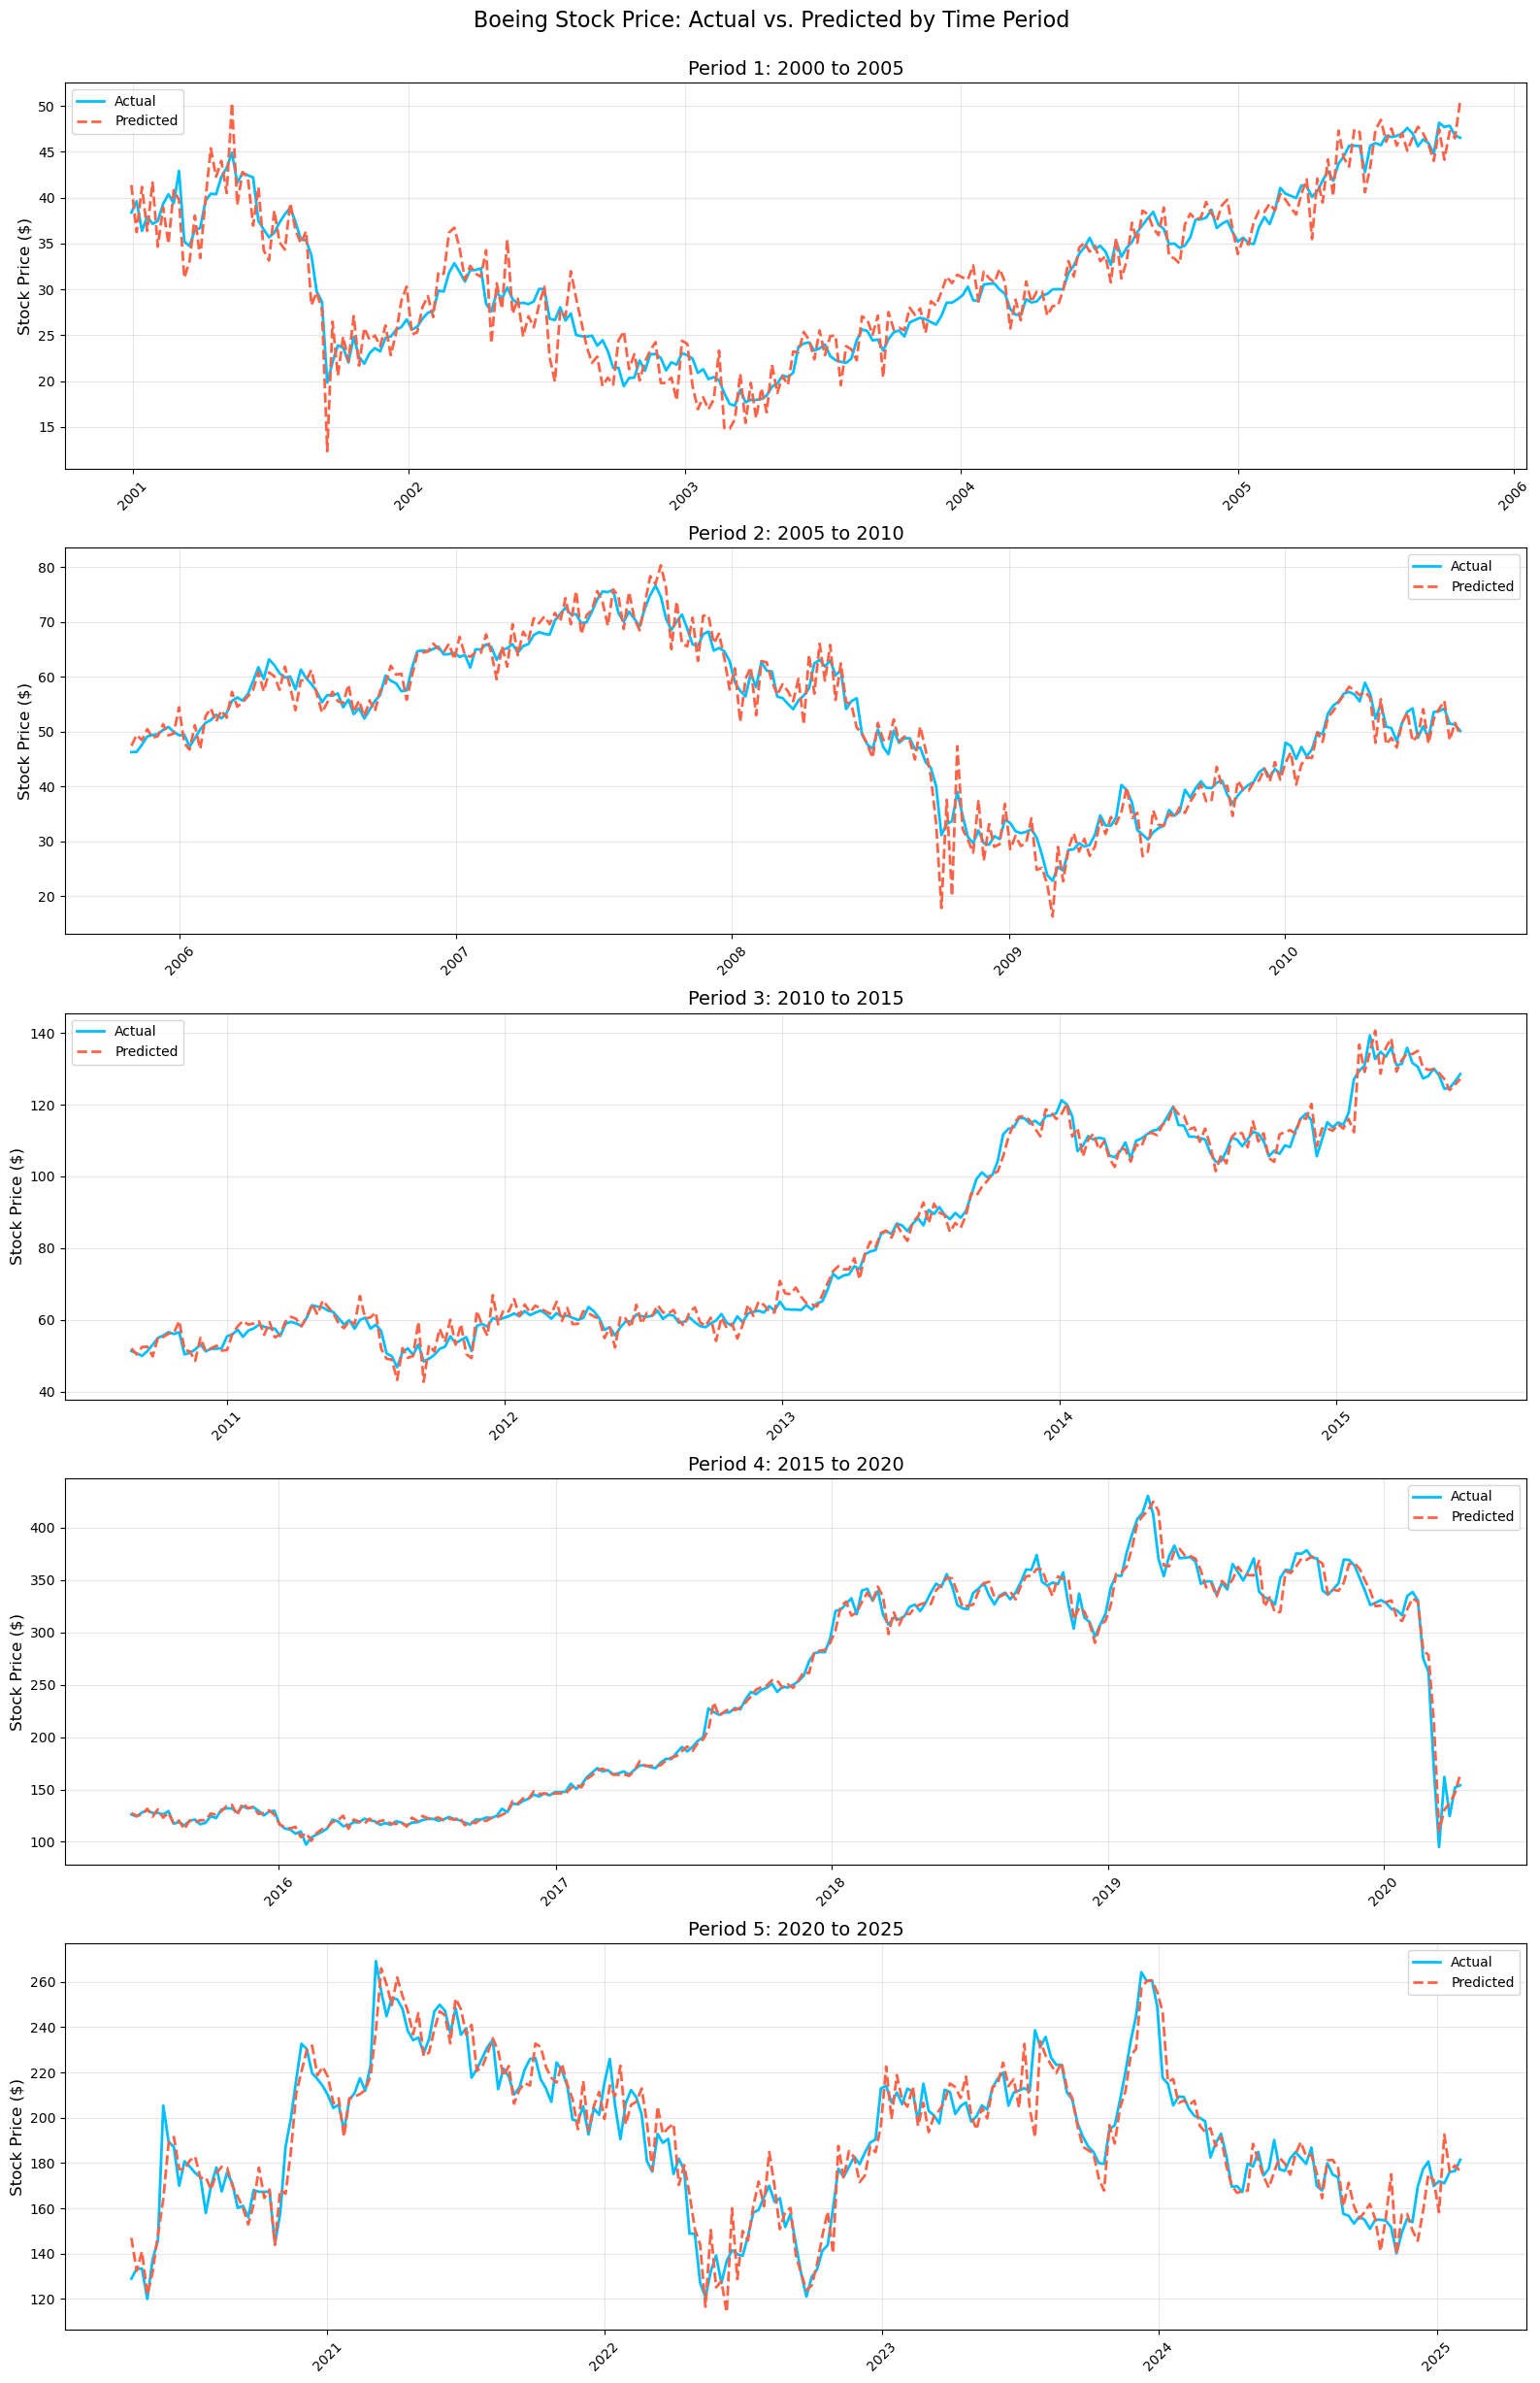

In [43]:
# To use this function, call it after running your model:
results = dynamic_regression_model(df)
plot_by_time_periods(results)